### Описание задачи

Задача данного учебного проекта является предобработкой (Data Preprocessing) и EDA анализом данных взятых с сайта "Kaggle"

__Описание дата сета:__
Набор данных «Продажи в грязном кафе» содержит 10 000 строк синтетических данных, представляющих собой транзакции по продажам в кафе. Этот набор данных намеренно «грязный», с пропущенными значениями, противоречивыми данными и ошибками, которые вводятся для создания реалистичного сценария очистки данных и исследовательского анализа данных (EDA). Его можно использовать для отработки методов очистки, обработки данных и разработки функций.

__Описание данных:__
* Transaction ID - Уникальный идентификатор для каждой транзакции. Всегда присутствует и уникален.
* Item - Название приобретенного товара. Может содержать пропущенные или недопустимые значения (например, «ERROR»).
* Quantity - Количество приобретенного товара. Может содержать пропущенные или недопустимые значения.
* Price Per Unit - Цена за единицу товара. Может содержать пропущенные или неверные значения.
* Total Spent - Общая сумма, потраченная на транзакцию. Рассчитывается как Quantity * Price Per Unit.
* Payment Method - Использованный способ оплаты. Может содержать отсутствующие или неверные значения (например, None, «UNKNOWN»).
* Location - Местоположение, в котором произошла транзакция. Может содержать отсутствующие или недопустимые значения.
* Transaction Date - Дата транзакции. Может содержать пропущенные или неправильные значения.

Набор данных включает в себя следующие пункты в меню ($):
* Coffe - 2 
* Tea - 1.5 
* Sandwich - 4 
* Salad - 5 
* Cake - 3 
* Cookie - 1 
* Smoothie - 4 
* Juice - 3


### 1. Загрузка и изучение информации

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [213]:
# считываем дата сет
df = pd.read_csv("data/dirty_cafe_sales.csv")
# посмотрим на данные
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [214]:
# все столбцы на первый взгляд вывелись коректно
# посмотрим информацию о данных
print(df.info())
print("---------------------------------------------")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB
None
---------------------------------------------
       Transaction ID   Item Quantity Price Per Unit Total Spent  \
count           10000   9667     9862           9821        9827   
unique          10000     10        7              8          19   
top       TXN_1961373  Juice        5            3.0         6.0   
freq                1   1171     2013           2429         979   


__Резюме:__ 
- У нас достаточно много пропусков в данных. Столбцы: Item, Quantity, Price Per Unit, Total Spent можно частично восстановить
- Столбец Transaction ID отвечающий за уникальность транзакций не содержит пропусков и дубликатов, соотвественно дубликатов в данных нету

### Предобработка данных 

- Столбец __Location__ имеет большое количество пропусков, поэтому мы не можем просто удалить эти данные. Обозначим все некорректные значение в этом столбце как UNKNOWN
- В остальных столбцах все некорректные данные приведем к типу NaN

In [218]:
# Удалим "Transaction ID" так как он будет не нужен
df = df.drop("Transaction ID", axis = 1)

# Заменим все значения "ERROR" и "UNKNOWN" в столбцах 0 1 2 3 и 6 на пропуски
df.iloc[:, [0, 1, 2, 3, 6]] = df.iloc[:, [0, 1, 2, 3, 6]].replace(["ERROR", "UNKNOWN"], np.nan)
# Заменим все пропуски и "ERROR" на  отдельную категория "UNKNOWN"
df.loc[:, ["Location", "Payment Method"]] = df.loc[:, ["Location", "Payment Method"]].replace(["ERROR"],["UNKNOWN"])
df.loc[:, ["Location", "Payment Method"]] = df.loc[:, ["Location", "Payment Method"]].fillna("UNKNOWN")

In [219]:
# Присвоим тип float64 числовым столбцам
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors = 'coerce')
df["Quantity"] = pd.to_numeric(df["Quantity"], errors = 'coerce')
df["Total Spent"] = pd.to_numeric(df["Total Spent"], errors = 'coerce')

__Удалим данные которые не восстановить__ , к ним относятся случаи когда:
- нельзя однозначно сопоставить "Item" с "Price Per Unit"
- пропущено значение "Transaction Date"
- пропущено значение "Quantity" или "Total Spent"

In [221]:
 # когда 'Item' и 'Price Per Unit' неизвестны
df = df[~(df['Item'].isna() & df['Price Per Unit'].isna())] 
 # если 'Price Per Unit' имеет 3 или 4 в значении, то при пустом 'Item' восстановить не получится однозначно, т.к. 3 и 4 не имеют уникального Item
df = df[~(df['Item'].isna() & ((df['Price Per Unit'] == 3.0) | (df['Price Per Unit'] == 4.0)))]
 # значение 'Transaction Date' не восстановить 
df = df.dropna(subset = ["Transaction Date"])
 # когда "Quantity" и "Total Spent" имеют пропуски одновременно их не восстановить
df = df.dropna(subset = ["Quantity", "Total Spent"], how = "all")

__Восстановим Item и Price Per Unit__
>Исходя из информации о данных, мы знаем, что каждый продукт имеет фиксированную цену, поэтому "Item" можно восстановить по "Price Per Unit". Справедливо и обратное.

In [223]:
# Восстановим данные "Price Per Unit" по значениям "Item"
# так как mean() игнорирует NaN мы можем присвоить каждому уникальному значению 'Item' среднее по 'Price Per Unit'
price = df.groupby('Item')["Price Per Unit"].mean()
df['new_price'] = df['Item'].map(price)
 # необходимо заполнить пропуски "new_price" т.к. в "Item" есть пропуски и это может внести лишние нули
df['new_price'] = df['new_price'].fillna(df['Price Per Unit'])
 # перенесем данные в один столбец
df['Price Per Unit'] = df['new_price']
 # удалим не нужный столбец
df = df.drop("new_price", axis = 1)

In [224]:
# Восстановим данные "Item" по уникальным значениям "Price Per Unit"
 # создадим серию, которая хранит уникальне значения "Price Per Unit"
unique_price = price[price.isin(price.value_counts()[price.value_counts() == 1].index)]
 # поменяем местами индексы и значения 
price_swapped = pd.Series(unique_price.index, index = unique_price.values)
price_swapped
 # заменим пропуски в "Item"
df['new_item'] = df['Price Per Unit'].map(price_swapped)
df['Item'] = df["Item"].fillna(df['new_item'])
df = df.drop("new_item", axis = 1)

__Восстановим Quantity и Total Spent__
> Когда мы устранили пропуски в "Price Per Unit" мы можем рассчитать значение "Quantity" и "Total Spent" по формуле __количество = сумма потраченных средств / цена__

In [226]:
# Восстановим "Quantity"
df["new_quantity"] = df["Total Spent"]/df["Price Per Unit"]
df["Quantity"] = df["Quantity"].fillna(df["new_quantity"])
df = df.drop("new_quantity", axis = 1)
# Восстановим "Total Spent"
df["new_total_spent"] = df["Quantity"]*df["Price Per Unit"]
df["Total Spent"] = df["Total Spent"].fillna(df["new_total_spent"])
df = df.drop("new_total_spent", axis = 1)

In [227]:
# посмотрим на данные после обработки 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9044 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Item              9044 non-null   object 
 1   Quantity          9044 non-null   float64
 2   Price Per Unit    9044 non-null   float64
 3   Total Spent       9044 non-null   float64
 4   Payment Method    9044 non-null   object 
 5   Location          9044 non-null   object 
 6   Transaction Date  9044 non-null   object 
dtypes: float64(3), object(4)
memory usage: 565.2+ KB
None


__Преобразуем 'Transaction Date' в формат даты__

In [229]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['month'] = df['Transaction Date'].dt.month
df['month'] = df['Transaction Date'].dt.month
df['day_of_week'] = df['Transaction Date'].dt.day_name()

__Резюме:__ 
* после отчистки и восстановления числовых данных мы сохранили около 90% информации. 
* в столбцах "Location" и "Payment Method" мы заменили пропуски и ERROR на UNKNOWN
* создали отельные столбцы "month" и "day_of_week"

### Анализ данных

Выведем основные статистические величины 

In [233]:
df.describe()

,Quantity,Price Per Unit,Total Spent,Transaction Date,month
count,9044.000000,9044.000000,9044.000000,9044,9044.000000
mean,3.017581,2.924370,8.836853,2023-07-01 18:16:23.989385216,6.516475
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00,1.000000
25%,2.000000,1.500000,4.000000,2023-03-31 00:00:00,3.000000
50%,3.000000,3.000000,7.500000,2023-07-02 00:00:00,7.000000
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00,10.000000
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00,12.000000
std,1.422097,1.299834,6.032960,NaN,3.450965


## Поиск выбросов

Заметим, что в столбце "Total Spent" мы видим, что максимальное значение сильно далеко ушло от 3го квартиля.
Посмотрим на выбросы с помощью boxplot

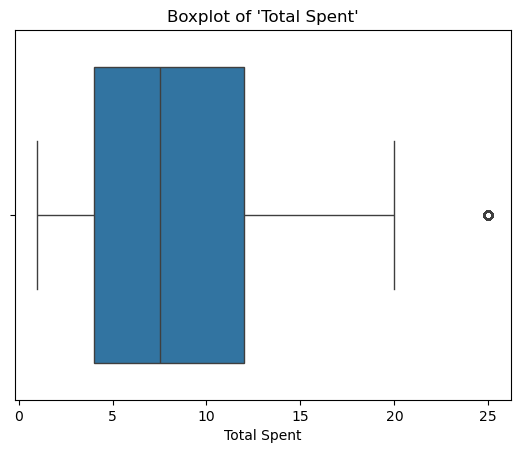

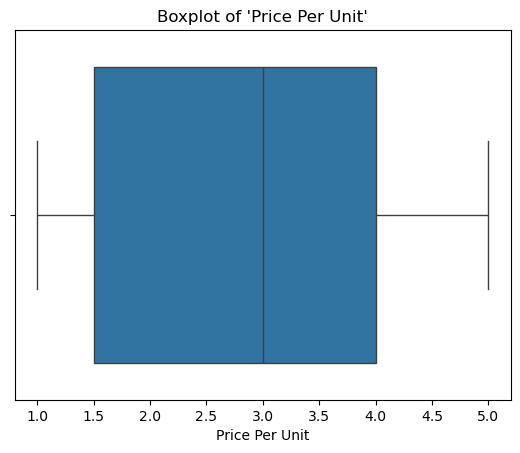

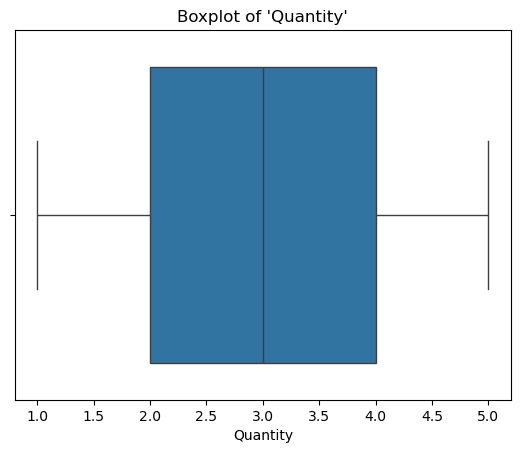

In [236]:
# Поиск выбросов
sns.boxplot(df['Total Spent'], orient = 'h')
plt.title("Boxplot of 'Total Spent'")
plt.show()

sns.boxplot(df['Price Per Unit'], orient = 'h')
plt.title("Boxplot of 'Price Per Unit'")
plt.show()

sns.boxplot(df['Quantity'], orient = 'h')
plt.title("Boxplot of 'Quantity'")
plt.show()


__Резюме:__ 
- Явных выбросов на графиках Quantity и Price Per Unit boxplot не обнаружилось
- Виден выброс в столбце Total Spent на границе 25, рассчитаем более подробный анализ границ

In [238]:
# Посмотрим на данные которые вышли за пределы усов 
pr_75 = df['Total Spent'].quantile(0.75)
pr_25 = df['Total Spent'].quantile(0.25)
IQR = pr_75 - pr_25
Outliers = df[(df['Total Spent'] > pr_75 + IQR*1.5) | (df['Total Spent'] < pr_25 - IQR*1.5)]['Total Spent']
print("уникальные выбросы: ", Outliers.unique())
print("количество выбрсоов: ", Outliers.count())

уникальные выбросы:  [25.]
количество выбрсоов:  259


In [239]:
# Отберем переменные, которые могут влиять на Total Spent
unique_outliers = df.loc[:, ['Item','Quantity','Price Per Unit','Total Spent']]
# Найдем уникальные строки
unique_outliers[(unique_outliers['Total Spent'] == 25)].drop_duplicates()

,Item,Quantity,Price Per Unit,Total Spent
10,Salad,5.0,5.0,25.0


__Резюме__: Мы имеем 259 одинаковых по числовым значениям и названию продукта. Из 9044 наблюдений 259 транзакций было совершенно клиентами, такое значение (25) можно считать валидным. Это указывает на определенный сегмент покупателей, совершающих покупки "Salad" по стоимости 5 в размере 5 единиц

## Анализ продаж

__построим диаграмму процентного распределения Quantity__

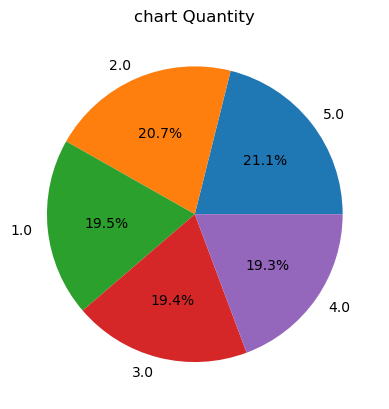

In [243]:
counts_quantity = df['Quantity'].value_counts()
percentages = round((counts_quantity  / df.shape[0]) * 100, 1)
plt.title('chart Quantity')
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%');

данные по Quantity показывают почти равномерное распределение (19.3% - 21.1%)

__Построим график проданого товара за все время__

top 8 popular Item: Item
Coffee      1234
Salad       1212
Cookie      1145
Tea         1134
Juice       1121
Cake        1081
Sandwich    1071
Smoothie    1046
Name: count, dtype: int64


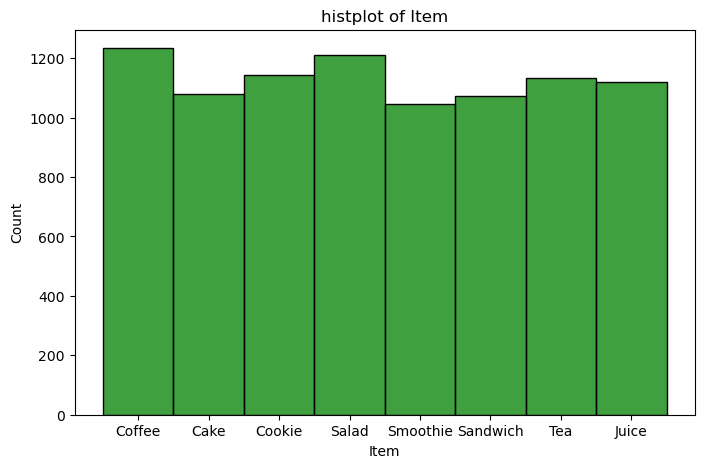

In [246]:
item_counts =  df['Item'].value_counts()
print("top 8 popular Item:", item_counts.sort_values(ascending = False).head(8))
plt.figure(figsize = (8,5))
sns.histplot(data = df, x = 'Item', color = 'green');
plt.title('histplot of Item');

* Самый часто покупаемый товар - Coffe
* Самый не популяпный - Smoothie 

__Найдем топ 10 популярных комбинаций Item и Quantity__

In [249]:
combinations = df.loc[:,['Item','Quantity']]
popular_comb = combinations.value_counts().sort_values(ascending = False).reset_index()
top_10_comb = popular_comb.head(10)
top_10_comb

,Item,Quantity,count
0,Coffee,5.0,268
1,Salad,5.0,259
2,Tea,2.0,257
3,Salad,1.0,251
4,Salad,2.0,251
5,Cookie,2.0,250
6,Coffee,3.0,247
7,Coffee,1.0,245
8,Coffee,2.0,241
9,Tea,5.0,240


__Рассмотрим объем продаж по дням недели__

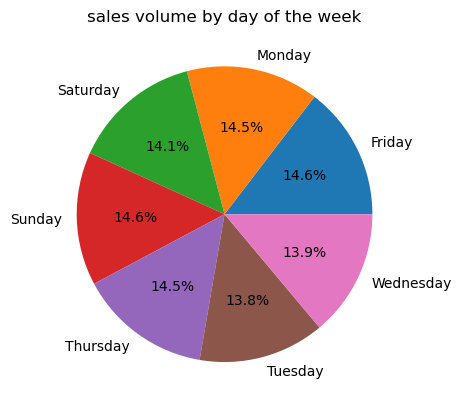

In [251]:
sales_week = df.groupby("day_of_week")['Item'].count()
percentages =  round((sales_week / df.shape[0]) * 100, 1)
plt.title('sales volume by day of the week')
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%');

На диаграмме видно практически равномерное распределение: объем продаж распределен довольно равномерно по всем дням недели. Разница между самым высоким (пятница и воскресенье — 14,6%) и самым низким (вторник — 13,8%) процентом невелика. Это значит, что день недели не сильно влияет на объем продаж. 

Визуализируем на тепловой карте продажи различных товаров по дням недели

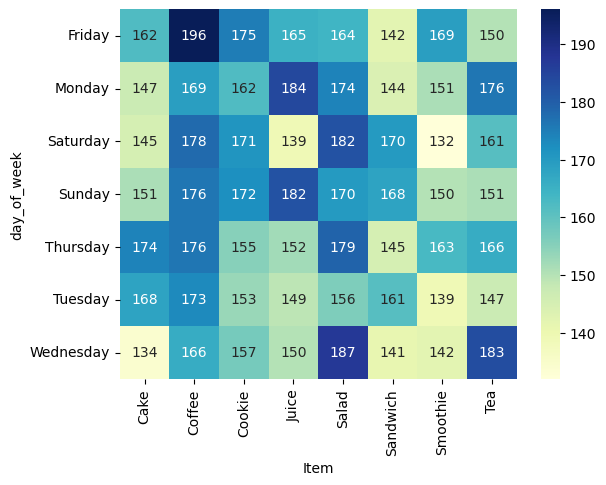

In [254]:
day_of_week_heatmap = df.groupby(['day_of_week', 'Item']).size().reset_index(name='count').pivot(index='day_of_week', columns='Item', values='count')
sns.heatmap(day_of_week_heatmap, annot=True, fmt=".0f", cmap="YlGnBu");

In [255]:
# создадим категории товара
drinks = ['Coffee', 'Juice', 'Smoothie', 'Tea']
dessert = ['Cookie', 'Cake']
snacks = ['Salad','Sandwich']

# создадим функцию, которая возвращает item-лидер из заданной категории для каждого дня недели
def get_category_leader(df, category):
    category_df = df[category]
    return category_df.idxmax(axis=1)


leaders_df = pd.DataFrame({
    'Drinks Leader': get_category_leader(day_of_week_heatmap, drinks),
    'Dessert Leader': get_category_leader(day_of_week_heatmap, dessert),
    'Snacks Leader': get_category_leader(day_of_week_heatmap, snacks)
})

print(leaders_df)

            Drinks Leader Dessert Leader Snacks Leader
day_of_week                                           
Friday             Coffee         Cookie         Salad
Monday              Juice         Cookie         Salad
Saturday           Coffee         Cookie         Salad
Sunday              Juice         Cookie         Salad
Thursday           Coffee           Cake         Salad
Tuesday            Coffee           Cake      Sandwich
Wednesday             Tea         Cookie         Salad


* Tea является самым популярным напитком в среду
* Cookie – явный лидер в категории "Dessert": Cookie лидирует почти каждый день
* Два основных лидера в категории "Drinks": Coffee и Juice доминируют в этой категории, причем Coffee чаще лидирует в будние дни (кроме среды), а Juice – в выходные. Это может указывать на разные модели потребления: кофе – для бодрости в рабочие дни, сок – для удовольствия в выходные.
* Salad – доминирующий продукт в категории "Snacks": Salad – явный лидер почти каждый день.

__Рассмотрим объем продаж по месяцам__

top 12 profitable months: month
10    805
3     793
1     783
6     769
7     756
8     752
11    751
9     744
12    740
4     733
5     732
2     686
Name: count, dtype: int64


<Figure size 1000x300 with 0 Axes>

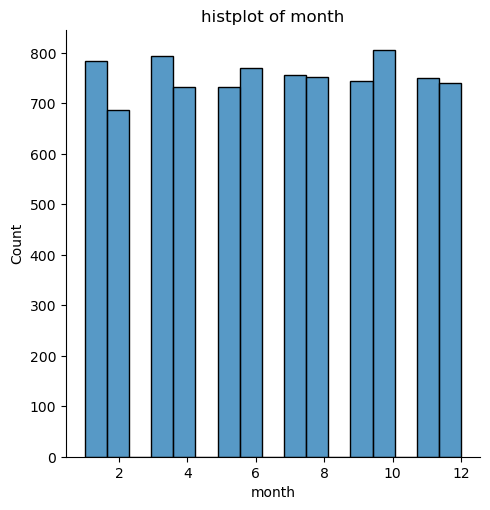

In [258]:
print("top 12 profitable months:", df['month'].value_counts().sort_values(ascending = False))
plt.figure(figsize = (10,3))
sns.displot(df['month']);
plt.title('histplot of month');

Данные показывают наличие выраженной сезонности в продажах. Октябрь является самым прибыльным месяцем, с пиком продаж в 805 единиц, февраль является самым слабым месяцем.

__Построим диаграмму данных "Payment Method"__ , которая будет отображать процент значений в данных

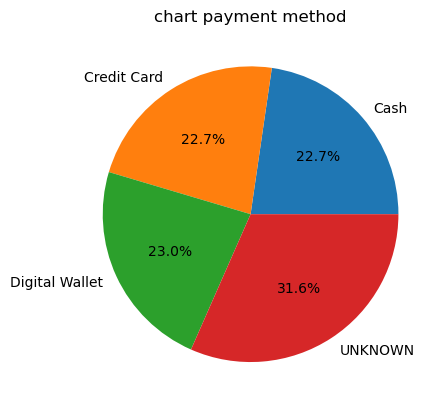

In [261]:
counts_payment = df.groupby("Payment Method")['Item'].count()
percentages =  round((counts_payment / df.shape[0]) * 100, 1)
plt.title('chart payment method')
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%');

__Построим диаграмму данных "Location"__, которая будет отображать процент значений в данных

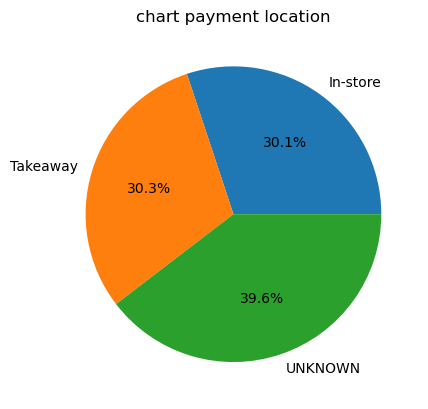

In [263]:
counts_location = df.groupby("Location")['Item'].count()
percentages =  round((counts_location / df.shape[0]) * 100, 1)
plt.title('chart payment location')
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%');

* Большую часть данных в "Payment Method" и "Location" нам неизвестна
* Остальные способы оплаты не имеют сильных различий в популярности
* Остальные локации не имеют сильных различий в популярности

__Рассчитаем общую сумму по каждому товару и выведем график доxода__

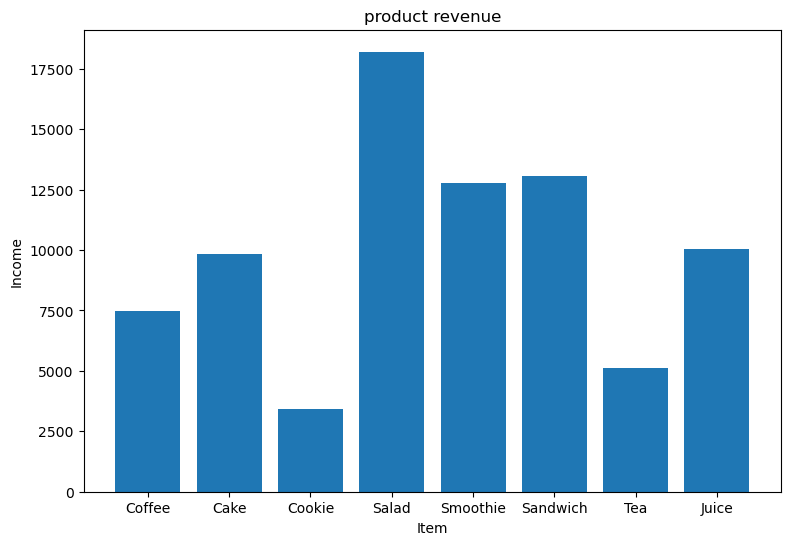

In [266]:
# доход за каждый товар
total_spent_sum = df["Item"].map(df.groupby("Item")["Total Spent"].sum())

plt.figure(figsize = (9,6))
plt.bar(df['Item'], total_spent_sum)
plt.title('product revenue')
plt.xlabel('Item')
plt.ylabel('Income')
plt.show()

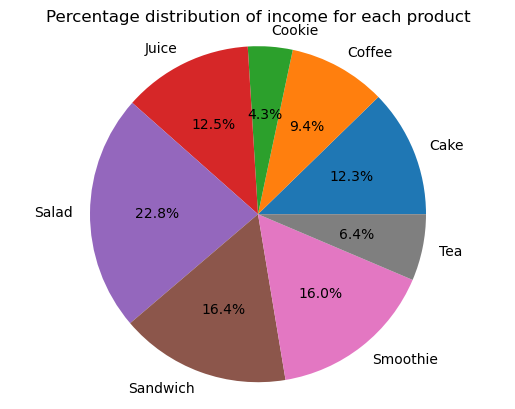

In [267]:
# теперь посмотрим график дохода по каждому товару в процентном соотношении 
total_spent_sum = df.groupby("Item")["Total Spent"].sum()
total_revenue = total_spent_sum.sum()
percentages = round((total_spent_sum / total_revenue) * 100, 1)

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%');
plt.title('Percentage distribution of income for each product')
plt.axis('equal')
plt.show()

### Заключение

__В результате предобработки данных было выполнено:__
* Удалось сохранить 9044 строк из 10 000
* В столбце "Location" и "Payment Method" значения "ERROR" и Nan были заменены на "UNKNOWN" 
* Дубликтов транзакций не обнаружилось, столбец Transaction ID был удален
* Были созданы стобцы "month" и "day_of_week" для дальнейшего анализа продаж

__В результате EDA анализа сделаны следующие выводы:__
* При исследовании выбросов в столбце "Total Spent" было обнаружено значение - 25 выходящее за пределы усов ящика с усами, проверив данные, я обнаружил, что мы имеем 259 строк (2.89% процента данных) являющихся редкой покупкой салата в количестве 5 единиц.
* Частота количества купленного товара на транзакцию равномерно распределенно от 1 до 5 единициц
* Три самых продоваемых продукта стали: кофе, салат, печенье
* Кофе — безусловный лидер: кофе является самым популярным товаром, и различные комбинации количества чашек кофе доминируют в топе. Самая популярная комбинация — 5 чашек кофе за раз. Также кофе часто берут в количествах 1 и 3, что говорит о разнообразии потребностей: кто-то берёт только для себя, кто-то — на компанию
* Салат также входит в число самых популярных товаров в сочетании с 5 единицами за транзакцию, а также по 1 и 2 штуке. Это может говорить о том, что салат часто берут на обед в одиночку или делят с коллегами.
* Комбинации чая в количестве 2х или 5ти единиц за транзакцию занимают 2е и 10е среди топа самых популярных комбинаций количества товара и продукта. Такие цифры могут говорить, о том, что чаще чай покупают на двоих или на компанию из 5 человек.
* Самый популярный десерт - печенье. Печенье также довольно часто покупают по 2 штуки.
* Большую часть информации о локациях и способе оплаты занимает "UNKNOWN", выявление причин UNKNOWN в данных требует дополнительного и большого анализа. Остальные способы оплаты и локации распределили почти одинаковое количество транзакций
* Наибольшую долю дохода принес салат (22.8%). Салат является самым дорогим товаром в кофейне, его часто покупают в количестве 5 единиц за раз, что может указывать на отдельный сегмент покупателей, который приобритает салат для нескольких человек
* Второе и третье место по уровню дохода заняли сэндвичи(22.8%) и смузи(16%), эти товары является наименее популярными, а так же одними из самых дорогих.
* Печенье и чай суммарно принесли всего (10.7%) дохода и стали наименнее доходными товарами